In [19]:
from loader1 import *
from utils import *

import warnings
warnings.filterwarnings('ignore')

In [20]:
_ = load_all()

Some files already exist in your CACHE_DIR. If you still want to run this function,              run with override=True


In [21]:
gps = read_data('gps')
orders = read_data('order')

In [22]:
# dropping duplicates
orders = orders.drop_duplicates()
gps = gps.drop_duplicates()

In [23]:
gps.shape, orders.shape

((32155517, 5), (181172, 7))

In [62]:
gps.head()

,driver_id,order_id,timestamp,longitude,latitude
0,8f20c9188561b796ef8e26196de30be4,39a096b71376b82f35732eff6d95779b,2016-11-01 02:59:07,104.07513,30.72724
1,8f20c9188561b796ef8e26196de30be4,39a096b71376b82f35732eff6d95779b,2016-11-01 02:59:10,104.07513,30.72702
2,8f20c9188561b796ef8e26196de30be4,39a096b71376b82f35732eff6d95779b,2016-11-01 02:59:14,104.07504,30.72672
3,8f20c9188561b796ef8e26196de30be4,39a096b71376b82f35732eff6d95779b,2016-11-01 02:59:16,104.07497,30.72630
4,8f20c9188561b796ef8e26196de30be4,39a096b71376b82f35732eff6d95779b,2016-11-01 02:59:19,104.07497,30.72582


In [27]:
# Run util functions
gps = convert_unix_ts(gps, timecols=['timestamp'])
orders = convert_unix_ts(orders, timecols=['ride_start_timestamp', 'ride_stop_timestamp'])
orders = ride_duration(orders)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'Timestamp'

In [ ]:
# Add driverid in orders column
drivers = gps[['driver_id', 'order_id']].drop_duplicates()
orders = orders.merge(drivers, on='order_id', how='left')

In [28]:
orders.head()

,order_id,ride_start_timestamp,ride_stop_timestamp,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_duration,driver_id
0,eb9dd4095d9850e6287cefd813775a6c,2016-11-01 01:46:37,2016-11-01 02:15:07,104.094640,30.703971,104.089270,30.650850,28.500000,0373c98625e6d8e1fc56a4d61318138c
1,387a742fa5a3fbe4a1f215ac58ea33a8,2016-11-01 07:33:05,2016-11-01 08:07:55,104.076509,30.767430,104.063700,30.589510,34.833333,0373c98625e6d8e1fc56a4d61318138c
2,9cf55f8e6e02a1e0f792df06e5d85011,2016-11-01 12:55:52,2016-11-01 13:16:57,104.019699,30.689007,104.105324,30.663950,21.083333,0373c98625e6d8e1fc56a4d61318138c
3,5feeae0307e15203484b9ffceef89855,2016-11-01 08:44:00,2016-11-01 09:04:25,104.036090,30.622690,104.043860,30.682320,20.416667,0373c98625e6d8e1fc56a4d61318138c
4,ad4b52cb15b90c44c8f20a8b1e57a622,2016-10-31 23:53:25,2016-11-01 00:02:57,104.115997,30.652313,104.104421,30.695113,9.533333,0373c98625e6d8e1fc56a4d61318138c


In [29]:
data = pd.DataFrame(orders.groupby('driver_id')['order_id'].count()).reset_index()
data.describe()

,order_id
count,35449.000000
mean,5.110779
std,3.983321
min,1.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,56.000000


In [18]:
data = pd.DataFrame(orders.groupby('driver_id')['order_id'].count()).reset_index()
data.describe()

,order_id
count,35449.000000
mean,5.907727
std,4.695150
min,1.000000
25%,2.000000
50%,5.000000
75%,8.000000
max,56.000000


In [40]:
data[data.order_id == 1]

,driver_id,order_id
3,0007a380800445346fff19afc4071ce3,1
5,00095da02ea38d4d8eaa120201e38ae9,1
8,000db06fb2f4a700c4105348643f593e,1
12,0012e784612e76e2fff36e9059798d15,1
19,001cd0f3067cbf5350d1ba26bee42f2a,1
...,...,...
35423,ffd6b480c8ba024b2e0036adf9a33989,1
35427,ffdc446be87bca34541f599cf4d2aad8,1
35430,ffe0beb28cd3549ddde3f97cec7a1edd,1
35433,ffeb34c832cbd003be8400a8b8f7da28,1


In [30]:
driver_ride_durations = orders.groupby('driver_id')[['ride_duration']].sum().reset_index()

In [31]:
driver_ride_durations.head()

,driver_id,ride_duration
0,0000131d486b69eb77ab6e9e7cca9f4c,75.583333
1,000211a97ba2b768ef941593bf1ae1a5,157.016667
2,000770ada4aa5d856b5a766fb6bf7cf1,87.900000
3,0007a380800445346fff19afc4071ce3,23.650000
4,0008c9d2ac91c00ef8b3ef80eba02a06,142.766667


### Single day total active time

In [54]:
driver_day_min = pd.DataFrame(orders.groupby('driver_id')['ride_start_timestamp'].min()).reset_index()
driver_day_max = pd.DataFrame(orders.groupby('driver_id')['ride_stop_timestamp'].max()).reset_index()
driver_active_time = driver_day_min.merge(driver_day_max, on='driver_id', how='left')
driver_active_time['active_time'] = (driver_active_time['ride_stop_timestamp'] - driver_active_time['ride_start_timestamp']).dt.total_seconds() / 60
driver_active_time.head()

,driver_id,ride_start_timestamp,ride_stop_timestamp,active_time
0,0000131d486b69eb77ab6e9e7cca9f4c,2016-11-01 03:57:05,2016-11-01 05:42:08,105.050000
1,000211a97ba2b768ef941593bf1ae1a5,2016-11-01 01:29:41,2016-11-01 13:51:06,741.416667
2,000770ada4aa5d856b5a766fb6bf7cf1,2016-11-01 01:04:52,2016-11-01 04:19:01,194.150000
3,0007a380800445346fff19afc4071ce3,2016-11-01 01:30:40,2016-11-01 01:54:19,23.650000
4,0008c9d2ac91c00ef8b3ef80eba02a06,2016-11-01 02:23:26,2016-11-01 16:07:35,824.150000


In [55]:
driver_active_time[driver_active_time.driver_id == '310c5f3ffed8d3d42b90583c596cfd8e']

,driver_id,ride_start_timestamp,ride_stop_timestamp,active_time
6722,310c5f3ffed8d3d42b90583c596cfd8e,2016-10-31 16:13:11,2016-11-01 16:14:58,1441.783333


### Comparing total driver active time vs ride time

In [56]:
# total driver active time
driver_stats = driver_active_time[['driver_id', 'active_time']].merge(driver_ride_durations, on='driver_id', how='left') 

# Filtering possible bad rows
# driver_stats = driver_stats[driver_stats.active_time > driver_stats.ride_duration]

driver_stats.describe()

,active_time,ride_duration
count,35449.000000,35449.000000
mean,339.820956,110.729417
std,342.241304,84.044857
min,0.066667,0.066667
25%,60.616667,44.533333
50%,218.300000,89.066667
75%,536.850000,156.600000
max,1509.083333,677.566667


In [58]:
driver_stats[driver_stats.ride_duration > driver_stats.active_time]

,driver_id,active_time,ride_duration
83,009ba30d83cca1e82e56473b0f029b3f,134.516667,144.100000
114,00ccfb73c0c901298550a92bbd64634f,56.550000,59.216667
137,00f549f0b3d5cbca2f730e2e82fa4956,84.966667,99.033333
146,010af431d87d4b94869d350e52a9af15,116.583333,143.833333
202,01847c337b2c50352d18fd97761ebb90,11.850000,20.800000
...,...,...,...
34838,fbb816f116ee93847ee135ed1b17c3c9,179.666667,181.816667
34841,fbbfdc879bef5583631d604d38ae5e06,35.066667,42.050000
35142,fddde617b89491aa6dc31892370fe1fa,196.966667,202.000000
35346,ff6bec7a59eaa062b15b940df40d3961,170.550000,231.316667


In [35]:
orders[orders.driver_id == '009ba30d83cca1e82e56473b0f029b3f']

,order_id,ride_start_timestamp,ride_stop_timestamp,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_duration,driver_id
99829,2cb29e4b3790b3ea794b53ea7b7c0dd3,2016-10-31 23:58:30,2016-11-01 00:13:07,104.081500,30.64822,104.05067,30.667610,14.616667,009ba30d83cca1e82e56473b0f029b3f
99830,95dedc5907922f8b3b6194d3b14936ec,2016-11-01 00:24:51,2016-11-01 00:54:42,104.054580,30.66078,104.03775,30.626180,29.850000,009ba30d83cca1e82e56473b0f029b3f
99831,0307f2cb4b7bc0ad9d45a17061cf61b2,2016-11-01 00:29:24,2016-11-01 01:17:51,104.045061,30.66770,103.98036,30.599709,48.450000,009ba30d83cca1e82e56473b0f029b3f
99832,0f02475cf7446a78204073036301ce7a,2016-10-31 23:03:20,2016-10-31 23:54:31,103.978780,30.66881,103.99858,30.675080,51.183333,009ba30d83cca1e82e56473b0f029b3f


In [61]:
orders[orders.driver_id == '010af431d87d4b94869d350e52a9af15'].sort_values('ride_start_timestamp')

,order_id,ride_start_timestamp,ride_stop_timestamp,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_duration,driver_id
99619,18383daef95e2f24f43be887d18bb4e4,2016-11-01 05:32:16,2016-11-01 06:25:03,104.237580,30.576851,104.11607,30.67694,52.783333,010af431d87d4b94869d350e52a9af15
99620,59a8f6390bead68a63358d4b790f64a2,2016-11-01 06:00:31,2016-11-01 06:43:28,104.131798,30.606470,104.07705,30.68931,42.950000,010af431d87d4b94869d350e52a9af15
99621,0f6913d71279c5585f8877b741aef25b,2016-11-01 06:47:28,2016-11-01 07:04:22,104.078857,30.687960,104.11126,30.67547,16.900000,010af431d87d4b94869d350e52a9af15
99622,dfb49c33e2bf102d2cf16a5e6ebd4e6e,2016-11-01 06:50:00,2016-11-01 07:15:51,104.079600,30.688130,104.10631,30.65612,25.850000,010af431d87d4b94869d350e52a9af15
99623,1625e89149f8ca2e88aafdea3f80b481,2016-11-01 07:23:30,2016-11-01 07:28:51,104.103239,30.656172,104.12043,30.65860,5.350000,010af431d87d4b94869d350e52a9af15


## Scatter plot of active time vs. ride duration

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

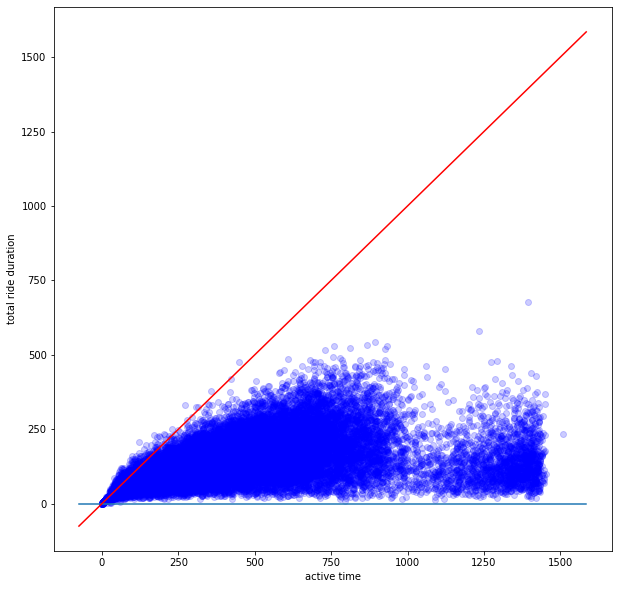

In [59]:
import numpy as np
fig, ax = plt.subplots(figsize=(10,10))
# plt.figure(figsize=(10,10))
plt.scatter(driver_stats['active_time'], driver_stats['ride_duration'], c='b', alpha=0.2)
plt.ylabel('total ride duration')
plt.xlabel('active time')
x = np.linspace(*ax.get_xlim())
plt.plot(x, [0]*len(x))
plt.plot(x, x, color='red')
# plt.plot()

In [50]:
driver_stats[(driver_stats.active_time < 5) & (driver_stats.active_time < driver_stats.ride_duration) ]

,driver_id,active_time,ride_duration
6722,310c5f3ffed8d3d42b90583c596cfd8e,1.783333,238.783333
8547,3dea37fb87bf56699fb94f8743f2c6a1,4.883333,96.916667
9003,412d8e7543decaac5845cd09b5035482,0.183333,212.166667
11829,558859731ebff03c1f4b2fe41e1eaf93,1.500000,227.333333
14347,67ffb0645faf24f6437e39329608c3a3,4.916667,69.916667
14777,6aef4441774d62941f6d6e42b6b9832d,4.083333,73.183333
21620,9d24aff823866443501479e3be6d47f4,1.666667,169.233333
24589,b2de9477265e51637360c833fc1c00f2,4.833333,84.466667
27423,c74ee86393fae5c91c2e03d257e4bfe7,4.583333,183.383333
28438,ce5f5e21adb57251548c36c8eaf39e34,4.650000,102.250000


In [52]:
orders[orders.driver_id== '310c5f3ffed8d3d42b90583c596cfd8e'].sort_values('ride_start_timestamp')

,order_id,ride_start_timestamp,ride_stop_timestamp,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_duration,driver_id
98558,9985835c1fb05409b04b3b6f02fd2db0,2016-10-31 16:13:11,2016-10-31 16:44:34,104.074333,30.706291,104.001191,30.656482,31.383333,310c5f3ffed8d3d42b90583c596cfd8e
98562,689a5bd74f0a3175015caa6914a70caa,2016-10-31 17:03:55,2016-10-31 17:46:49,104.013680,30.645921,104.048830,30.679040,42.900000,310c5f3ffed8d3d42b90583c596cfd8e
98551,a8386ee421bab7d314d5f0c607401c4e,2016-11-01 06:03:28,2016-11-01 06:20:00,104.073898,30.689899,104.085790,30.662040,16.533333,310c5f3ffed8d3d42b90583c596cfd8e
98552,3f86f3c30dcd2845894d940352b78294,2016-11-01 06:24:47,2016-11-01 06:33:33,104.087740,30.665410,104.110330,30.665860,8.766667,310c5f3ffed8d3d42b90583c596cfd8e
98553,01af8c00e8676c7af81dc87b4d7063a7,2016-11-01 06:36:31,2016-11-01 06:48:12,104.105340,30.667330,104.086160,30.650810,11.683333,310c5f3ffed8d3d42b90583c596cfd8e
98554,a4de3e7a5cfd435b2184ce6a7170c673,2016-11-01 06:49:56,2016-11-01 06:52:59,104.086310,30.651290,104.086410,30.656460,3.050000,310c5f3ffed8d3d42b90583c596cfd8e
98555,757076750a59f2c68c975b124b6f82de,2016-11-01 06:59:44,2016-11-01 07:12:52,104.086830,30.654180,104.057850,30.659160,13.133333,310c5f3ffed8d3d42b90583c596cfd8e
98560,422f51fc32202cc750cba400fe4200ed,2016-11-01 07:19:07,2016-11-01 07:44:32,104.055370,30.657690,104.141620,30.628690,25.416667,310c5f3ffed8d3d42b90583c596cfd8e
98556,d5331b1817de10b3ee4688792ef75233,2016-11-01 12:43:33,2016-11-01 12:56:19,104.054160,30.677890,104.059650,30.666480,12.766667,310c5f3ffed8d3d42b90583c596cfd8e
98557,d3ef502e88983df7a1ed34326c156f65,2016-11-01 12:53:32,2016-11-01 13:19:46,104.053810,30.668380,104.094510,30.612170,26.233333,310c5f3ffed8d3d42b90583c596cfd8e


In [ ]:
driver_stats[(driver_stats.ride_duration < driver_stats.active_time  ]